# Key Contributions

1. CIRL framework: arguments deep RL policies with an embedded PID controller layer. This enables the agent to learn adaptive PID gain tuning while preserving the stabilizing properties and interpretability of PID control, effectively acting as an automated gain scheduler.
2. Demonstrate the CIRL framework on a nonlinear continuously CSTR system. The CIRL agent improves setpoint tracking performance compared to both a static PID controller and a standard model-free deep RL approach, particularly when generalizing to operating regions outside the training distribution.
3. By leveraging the embedded prior knowledge from the PID structure, the CIRL agent exhibits enhanced robustness to process disturbances that are not observable during training.
   

# Methodology

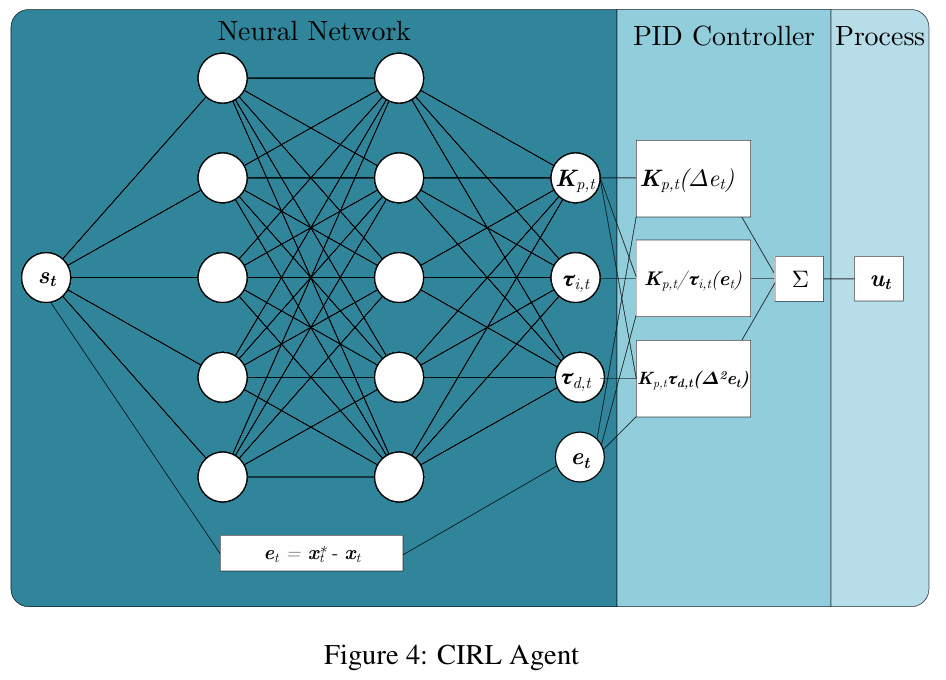
1. The base NN takes the observed states as inputs and outputs the PID gain parameters at each timestep t. The PID controller layer then computes the control action based on the error signal and the current learned gain parameters.
2. Through interacting with the environment, the CIRL agent aims to maximize the cumulative reward at each time step. The reward function is similar to that of MPC: a squared error term penalizes deviations of the controlled variable from the setpoint, with larger deviations penalized more heavily.
3. Important to note that derivative information is not passed between the PID controller and the NN in the CIRL agent architecture, as the evolutionary optimization strategy is taken. (Future study: integrated gradient-based learning strategy)


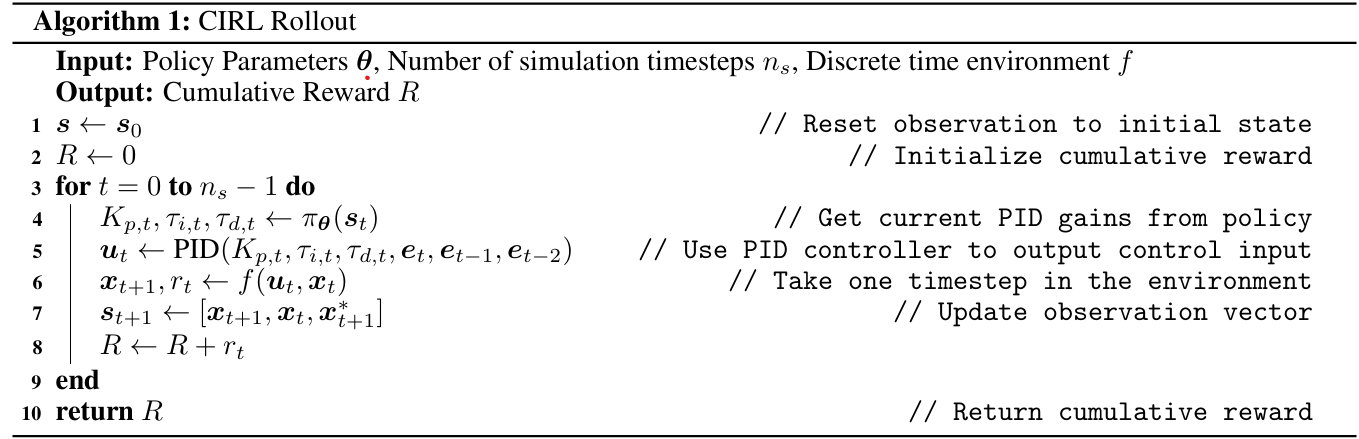
_Policy Optimization_

1. In this work, the CIRL agent's policy is optimized using a hybrid approach based on evolutionary strategies, combining random search and particle swarm optimization (PSO). A population of candidate policy parameter vectors is initialized by sampling randomly from the allowable ranges for each parameter dimension (weights of NN).
2. The best, or fittest, policies from this initial random sampling are carried forward as seeds to initialize the PSO phase of the algorithm. The PSO phase is then started, allowing policy parameter vectors to explore areas around the initially fit random vectors in a more structured manner.
3. Advantage: This hybrid approach leverages the gloabl exploration capabilities of intial random sampling, while also taking advantage of the PSO's ability to collaboratively focus its search around promising areas identified by the initial random search.
4. The CIRL framework is agnostic to the policy optimization strategyu, i.e., policy gradients or other policy optimization techniques can be used. The choice of evolutionary algorithms in the work is motivated by optimization performance given the small size of the neural network, as well as robustness in training.

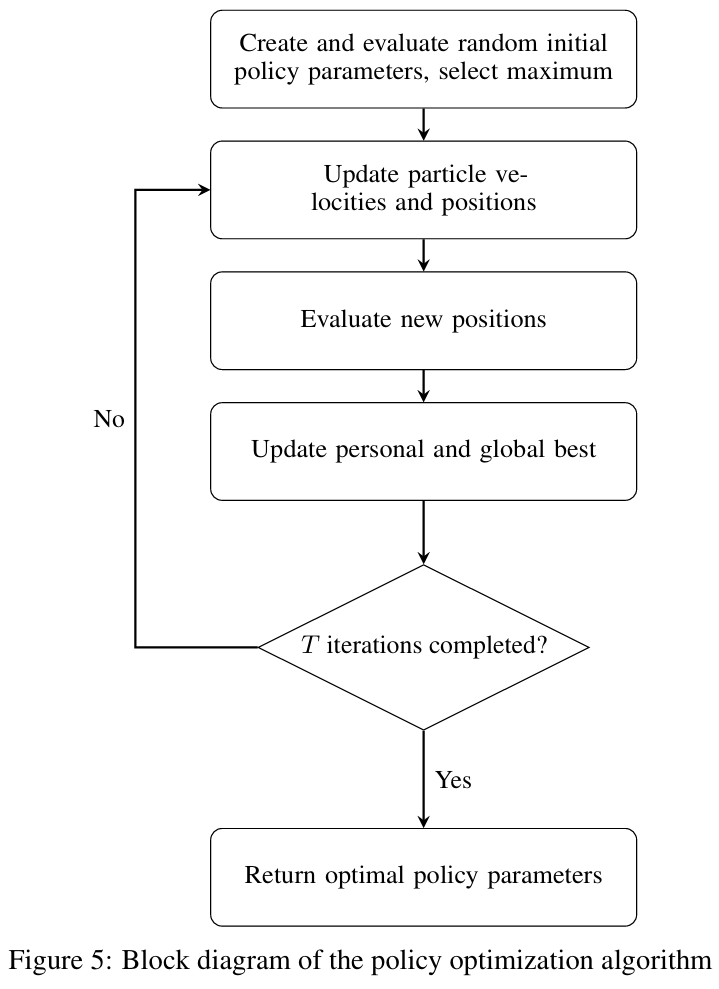

### 1. Policy Definition: Net Class

* Purpose: define the policy $\pi_{\theta}$ -- a NN that outputs either:
  * PID gains for each channel (when PID=True, have 6 outputs for controlling 2 channels).
  * Direct control actions (if PID=False, output 2D or 4D actions)

* Output range: The final layer uses tanh. The environment or PID function will then scale these appropriately.

In [ ]:
import torch
import torch.nn.functional as F

class Net(torch.nn.Module):
    def __init__(self, n_fc1, n_fc2, activation, n_layers, input_sz, output_sz, PID, **kwargs):
        super(Net, self).__init__()
        # Example hyperparameters
        self.hidden1 = torch.nn.Linear(input_sz, n_fc1, bias=True)
        self.hidden2 = torch.nn.Linear(n_fc1, n_fc2, bias=True)
        self.n_layers = torch.nn.ModuleList([
            torch.nn.Linear(n_fc2, n_fc2) for _ in range(n_layers)
        ])
        self.output = torch.nn.Linear(n_fc2, output_sz, bias=True)
        self.act = activation()

    def forward(self, x):
        x = x.float()
        y = self.act(self.hidden1(x))
        y = self.act(self.hidden2(y))
        # Potentially apply more layers here if `n_layers > 0`
        out = self.output(y)
        # y = F.tanh(out)
        # Which maps outputs to [-1,1].
        return F.tanh(out)


### 2. Environment Dynamics: reactor_class

* The environment class inherits gym.Env, reset() -> step (action) -> (observation, rewrad, done, ...) of typical RL frameworks.
* PID vs. Direct Control:
  * PID=True: the NN's 6D outputs are interpreted as three pairs of $(K_p, \tau_i, \tau_d)$ for two loops, or some variation. Use the PID_velocity to get actual control action for each step.
  * PID=False: the network might output a 2D vector mapped directly to [Tc, F]

In [ ]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np
from scipy.integrate import odeint

def PID_velocity(Ks, e, e_history, u_prev, ts, s_hist):
    # Implements velocity-form PID control using the “gains” from the policy.
    # Returns a clamped control action [Tc, F].

def cstr_CS1(x, t, u, Tf, Caf):
    # ODE function: the continuous-time CSTR model.
    # Defines how state evolves from x_t to x_{t+1} under control input u.

class reactor_class(gym.Env):
    def __init__(...):
        # 1) Sets up environment parameters: setpoints, time horizons, etc.
        # 2) Defines action and observation spaces for RL.

    def reset(self, seed=None):
        # Resets environment state, returns normalized observation.

    def step(self, action_policy):
        # 1) Convert the policy’s output to PID gains or direct actions.
        # 2) If using PID, call 'PID_velocity(...)' to get actual [Tc, F].
        # 3) Integrate the ODE over one time-step (using 'odeint').
        # 4) Compute the reward.
        # 5) Return (obs, reward, done, truncated, info).

    def reactor(self, state, action, Ca_des, V_des):
        # 1) Parse current state, compute error = setpoint - measured
        # 2) If PID, compute actual actuator commands via 'PID_velocity'.
        # 3) Integrate the system with 'odeint' from t to t+1
        # 4) Add measurement noise, build new state, compute cost/reward
        # 5) Return new state plus the immediate reward.


### 3. Training/Rollout Logic: CIRL Training

* Rollout Loop (criterion):
  * resets environment
  * interacts step by step
  * accumulates a reward
  * returns an average performance metric

* Optimization:
  * random search: find a decent initial solution
  * PSO: optimize the policy parameters


In [ ]:
import torch
import numpy as np
from cirl_policy import Net
# from cstr_model import reactor_class
from torch_pso import ParticleSwarmOptimizer
import pickle

class CIRLTraining:
    def __init__(...):
        # Sets up hyperparameters for training (network sizes, iteration counts, etc.)

    @staticmethod
    def sample_uniform_params(params_prev, param_max, param_min):
        # Helper: random initialization of network weights in a certain range.

    @staticmethod
    def criterion(policy, env):
        # 1) Runs multiple episodes in the environment using 'policy'
        # 2) For each episode:
        #       s, _ = env.reset()
        #       while not done:
        #           a = policy(s)  # neural net output
        #           s, reward, done, truncated, info = env.step(a)
        #           accumulates 'rew'
        # 3) Returns the *average* reward (or cost) over these episodes.

    def training_loop(self, PID, dist_train, n_fc, highop=False):
        # 1) Creates a Net() policy
        # 2) Creates the environment
        # 3) Does random search (30 random initializations), picks best
        # 4) Runs PSO (Particle Swarm Optimizer) to improve policy:
        #       for i in range(self.max_iter):
        #           optim.step(closure)  # closure calls 'self.criterion'
        # 5) Returns best policy & historical stats

    def sp_tracking_train(self, net_size_analysis=False):
        # Runs multiple training reps of:
        #   - CIRL (PID=True) training
        #   - RL (PID=False) training
        # Then saves the results.


# Simple Example: First-Order tank level environment (for testing)

An SISO example that keeps the overall structure (policy -> PID -> environment).

Discrete-time first-order process:

$$ x_{k+1} = \alpha x_k + \beta u_k $$

where
* $x_k$ is the tank level
* $u_k$ is the control input
* $\alpha, \beta$ are constatnts in (0,1) for stability
* want to track setpoint $x_{des}$

PID = True: policy network outputs ${K_p, \tau_i, \tau_d}$ feed into a velocity-form PID to produce the actual control $u_k$.


In [1]:
!pip install torch-pso

[RandomSearch] best_reward=-3.576
[PSO iter:1] cost=3.044 (reward ~ -3.044), best=-3.044
[PSO iter:2] cost=2.592 (reward ~ -2.592), best=-2.592
[PSO iter:3] cost=2.456 (reward ~ -2.456), best=-2.456
[PSO iter:4] cost=2.436 (reward ~ -2.436), best=-2.436
[PSO iter:5] cost=2.428 (reward ~ -2.428), best=-2.428
[PSO iter:6] cost=2.421 (reward ~ -2.421), best=-2.421
[PSO iter:7] cost=2.407 (reward ~ -2.407), best=-2.407
[PSO iter:8] cost=2.344 (reward ~ -2.344), best=-2.344
[PSO iter:9] cost=2.303 (reward ~ -2.303), best=-2.303
[PSO iter:10] cost=2.282 (reward ~ -2.282), best=-2.282
[PSO iter:11] cost=2.276 (reward ~ -2.276), best=-2.276
[PSO iter:12] cost=2.276 (reward ~ -2.276), best=-2.276
[PSO iter:13] cost=2.240 (reward ~ -2.240), best=-2.240
[PSO iter:14] cost=2.240 (reward ~ -2.240), best=-2.240
[PSO iter:15] cost=2.240 (reward ~ -2.240), best=-2.240
[PSO iter:16] cost=2.240 (reward ~ -2.240), best=-2.240
[PSO iter:17] cost=2.240 (reward ~ -2.240), best=-2.240
[PSO iter:18] cost=2.23

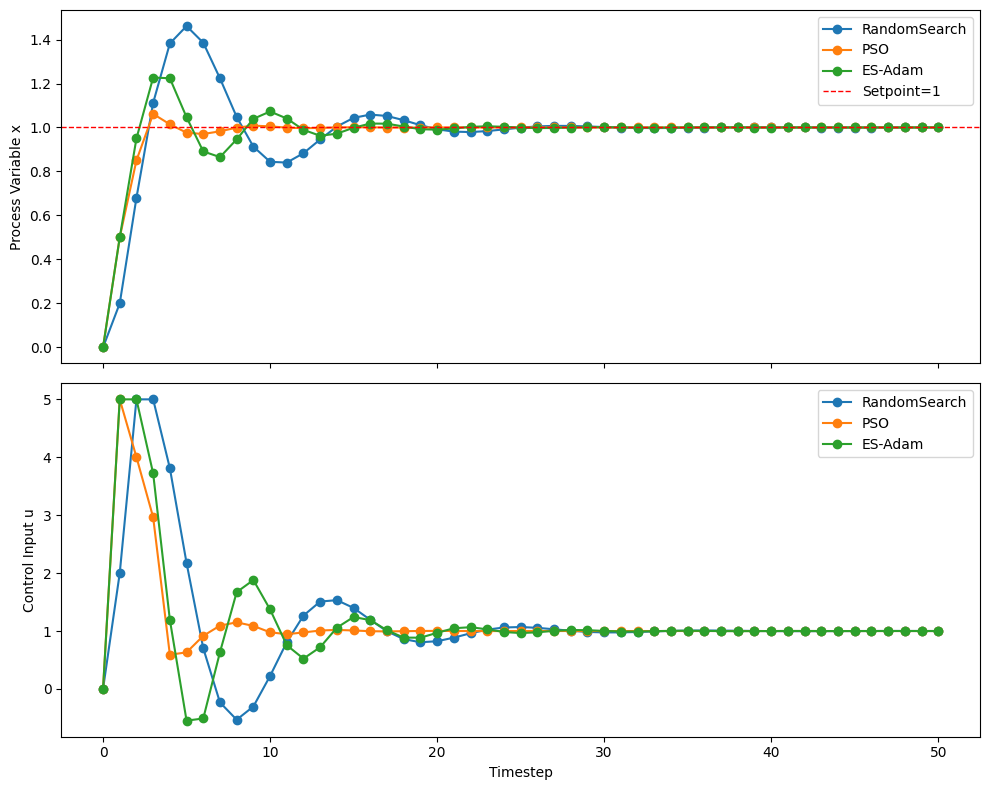

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import gym
from gym import spaces

from torch_pso import ParticleSwarmOptimizer
import copy

############################################
## Environment
############################################

def pid_velocity(Kp, Ti, Td, e, e_history, u_prev):
    """
    Velocity-form PID:
        Δu_k = Kp[ e_k - e_{k-1} ]
              + (Kp / Ti)* e_k
              - Kp*Td[ e_k - 2*e_{k-1} + e_{k-2} ]
    (dt=1.0 for simplicity.)
    """
    dt = 1.0
    e_k   = e
    e_km1 = e_history[-1] if len(e_history)>0 else 0.0
    e_km2 = e_history[-2] if len(e_history)>1 else 0.0

    Ti = max(Ti, 1e-6)  # avoid division by zero

    delta_u = (Kp*(e_k - e_km1)
               + (Kp / Ti)*e_k*dt
               - Kp*Td*(e_k - 2*e_km1 + e_km2)/dt)

    u_k = u_prev + delta_u
    # clamp for realism
    u_k = np.clip(u_k, -5, 5)
    return u_k

class ToyTankEnv(gym.Env):
    """
    Discrete-time SISO:
        x_{k+1} = alpha*x_k + beta*u_k
    Goal: track x_des=1.0.
    Action => either (Kp,Ti,Td) if pid_mode=True,
               or direct control if pid_mode=False.
    """
    def __init__(self, alpha=0.9, beta=0.1, horizon=40, pid_mode=True):
        super().__init__()
        self.alpha = alpha
        self.beta  = beta
        self.horizon = horizon
        self.pid_mode = pid_mode

        self.observation_space = spaces.Box(low=-5, high=5, shape=(1,), dtype=np.float32)

        if pid_mode:
            # 3D action => [Kp, Ti, Td] in [-1,1]
            self.action_space = spaces.Box(low=-1, high=1, shape=(3,), dtype=np.float32)
        else:
            # 1D direct control in [-1,1]
            self.action_space = spaces.Box(low=-1, high=1, shape=(1,), dtype=np.float32)

        self.reset()

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.t = 0
        self.x = 0.0
        self.x_des = 1.0
        self.done = False

        self.e_history = []
        self.u_history = [0.0]
        return np.array([self.x], dtype=np.float32), {}

    def step(self, action):
        if self.done:
            raise RuntimeError("Episode finished. Call reset().")

        e = self.x_des - self.x

        if self.pid_mode:
            # map [-1,1] => (Kp,Ti,Td) in some positive range
            Kp = 2.0*(action[0] + 1)   # [0..4]
            Ti = 1.0*(action[1] + 1)   # [0..2]
            Td = 1.0*(action[2] + 1)   # [0..2]
            u_prev = self.u_history[-1]
            u_k = pid_velocity(Kp, Ti, Td, e, self.e_history, u_prev)
        else:
            # direct control in [-5..5]
            u_k = 5.0 * action[0]

        # system update
        x_next = self.alpha*self.x + self.beta*u_k

        # cost
        cost = e**2 + 0.01*(u_k**2)

        self.x = x_next
        self.e_history.append(e)
        self.u_history.append(u_k)
        self.t += 1
        if self.t>=self.horizon:
            self.done=True

        obs = np.array([self.x], dtype=np.float32)
        reward = -cost
        return obs, reward, self.done, False, {}

#######################################
## Policy Network (NN)
#######################################

class PolicyNet(nn.Module):
    def __init__(self, input_size=1, hidden_size=16, output_size=3):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return torch.tanh(self.out(x))

##########################################
##  EVALUATION FUNCTION
##########################################
def evaluate_policy(policy, pid_mode=True, episodes=3, horizon=50):
    """
    Runs multiple episodes in the environment, returns average reward.
    """
    rewards = []
    for _ in range(episodes):
        env = ToyTankEnv(pid_mode=pid_mode, horizon=horizon)
        obs, _ = env.reset()
        done=False
        total_r = 0
        while not done:
            with torch.no_grad():
                inp = torch.tensor(obs, dtype=torch.float32).unsqueeze(0)
                action = policy(inp).squeeze(0).numpy()
            obs, r, done, _, _ = env.step(action)
            total_r += r
        rewards.append(total_r)
    return np.mean(rewards)

##########################################
## RANDOM SEARCH
##########################################
def random_search_training(pid_mode=True, n_random=20):
    # Build a "base" policy
    policy = PolicyNet(
        input_size=1,
        hidden_size=16,
        output_size=3 if pid_mode else 1
    )
    best_policy = copy.deepcopy(policy)
    best_reward = -1e10

    # We'll do n_random random initializations
    for _ in range(n_random):
        # Re-randomize policy
        def init_weights(m):
            if isinstance(m, nn.Linear):
                nn.init.uniform_(m.weight, -0.1, 0.1)
                nn.init.zeros_(m.bias)
        policy.apply(init_weights)

        r = evaluate_policy(policy, pid_mode=pid_mode)
        if r>best_reward:
            best_reward = r
            best_policy = copy.deepcopy(policy)

    print(f"[RandomSearch] best_reward={best_reward:.3f}")
    return best_policy, best_reward


##########################################
## PSO TRAINING
##########################################
def pso_training(pid_mode=True, max_iter=20, num_particles=30):
    """
    Use torch_pso to do blackbox optimization of policy params.
    We interpret 'evaluate_policy' as the objective to maximize,
    so we'll minimize cost = -reward in the closure.
    """
    # Build policy
    policy = PolicyNet(
        input_size=1,
        hidden_size=16,
        output_size=3 if pid_mode else 1
    )

    # Create optimizer
    optimizer = ParticleSwarmOptimizer(
        policy.parameters(),
        num_particles=num_particles,
        max_param_value=0.1,  # clamp param range
        min_param_value=-0.1,
        inertial_weight=0.7,
    )

    best_policy = copy.deepcopy(policy)
    best_reward = -1e10

    for i in range(max_iter):
        def closure():
            optimizer.zero_grad()
            # Evaluate => negative reward is the cost
            r = evaluate_policy(policy, pid_mode=pid_mode)
            return -r  # want to MINIMIZE cost => - reward

        cost = optimizer.step(closure)
        # cost is average of swarm's cost => we can track global best easily
        # Evaluate new policy
        r_eval = evaluate_policy(policy, pid_mode=pid_mode)
        if r_eval>best_reward:
            best_reward = r_eval
            best_policy = copy.deepcopy(policy)

        print(f"[PSO iter:{i+1}] cost={cost:.3f} (reward ~ {-cost:.3f}), best={best_reward:.3f}")

    return best_policy, best_reward


##########################################
## EVOLUTION STRATEGIES + ADAM
##########################################
class ESAdamTrainer:
    """
    A simple Evolution Strategies approach using Adam as the parameter update rule:
      1) sample param perturbations from N(0, sigma^2)
      2) evaluate each
      3) compute a gradient estimate
      4) update with Adam
    """
    def __init__(self, policy, pid_mode=True, population=10, sigma=0.1, lr=0.02):
        self.policy    = policy
        self.pid_mode  = pid_mode
        self.population = population
        self.sigma     = sigma
        self.optimizer = torch.optim.Adam(self.policy.parameters(), lr=lr)

    def train_step(self):
        """
        Single iteration of ES:
          - sample 'population' perturbations
          - evaluate each
          - compute gradient wrt params
          - update
        """
        # Flatten current policy parameters into a single vector
        params_vector = parameters_to_vector(self.policy)

        # For each sample in the population,
        # add random noise and measure performance
        epsilons = []
        rewards  = []

        for _ in range(self.population):
            epsilon = torch.randn_like(params_vector)*self.sigma
            epsilons.append(epsilon)

            # Positive perturbation
            vector_to_parameters(params_vector + epsilon, self.policy)
            r_pos = evaluate_policy(self.policy, pid_mode=self.pid_mode, episodes=1, horizon=40)

            # Negative perturbation
            vector_to_parameters(params_vector - epsilon, self.policy)
            r_neg = evaluate_policy(self.policy, pid_mode=self.pid_mode, episodes=1, horizon=40)

            # Collect combined result => finite difference
            rewards.append((r_pos, r_neg))

        # Now revert policy to original params
        vector_to_parameters(params_vector, self.policy)

        # Compute gradient estimate
        #  grad ~ (1 / (2*sigma)) * sum( (r_pos - r_neg)* epsilon )
        grad_est = torch.zeros_like(params_vector)
        for eps, (r_p, r_n) in zip(epsilons, rewards):
            grad_est += (r_p - r_n)*eps
        grad_est /= (2*self.sigma*self.population)

        # We'll do an Adam step by *manually* setting the grad, then calling optimizer.step()
        self.optimizer.zero_grad()
        # Put this grad into policy parameters
        vector_to_parameters(params_vector, self.policy)  # ensure policy is at base
        # we need to do "param.grad = dLoss/dParam" for each param
        apply_grad_to_parameters(self.policy, grad_est, negative=True)
        # negative=True => we maximize reward => so the 'loss' is -reward

        self.optimizer.step()

        # Evaluate final policy
        current_r = evaluate_policy(self.policy, pid_mode=self.pid_mode, episodes=3)
        return current_r


def parameters_to_vector(policy):
    """Flatten all parameters into a single torch vector."""
    return torch.cat([p.view(-1) for p in policy.parameters()], dim=0)

def vector_to_parameters(vector, policy):
    """Load a flat vector into the policy's parameters in-place."""
    idx = 0
    for p in policy.parameters():
        numel = p.numel()
        shape = p.shape
        p.data = vector[idx:idx+numel].view(shape).clone()
        idx += numel

def apply_grad_to_parameters(policy, grad_vector, negative=False):
    """Assign grad_vector to .grad for each parameter (for an Adam step)."""
    idx = 0
    sign = -1.0 if negative else 1.0
    for p in policy.parameters():
        numel = p.numel()
        shape = p.shape
        g = grad_vector[idx:idx+numel].view(shape)
        p.grad = sign*g.clone()
        idx += numel


def es_adam_training(pid_mode=True, max_iter=20, population=10, sigma=0.1, lr=0.02):
    policy = PolicyNet(
        input_size=1,
        hidden_size=16,
        output_size=3 if pid_mode else 1
    )
    trainer = ESAdamTrainer(policy, pid_mode=pid_mode, population=population, sigma=sigma, lr=lr)
    best_policy = copy.deepcopy(policy)
    best_reward = -1e10

    for i in range(max_iter):
        r = trainer.train_step()
        if r>best_reward:
            best_reward = r
            best_policy = copy.deepcopy(policy)
        print(f"[ES-Adam Iter:{i+1}] reward={r:.3f}, best={best_reward:.3f}")

    return best_policy, best_reward


##########################################
## COMPARE ALL THREE ALGORITHMS
##########################################
def compare_algorithms(pid_mode=True):
    # 1) Random search
    rs_policy, rs_best = random_search_training(pid_mode=pid_mode, n_random=20)

    # 2) PSO
    pso_policy, pso_best = pso_training(pid_mode=pid_mode, max_iter=20, num_particles=15)

    # 3) ES + Adam
    esadam_policy, esadam_best = es_adam_training(pid_mode=pid_mode, max_iter=20, population=10, sigma=0.1, lr=0.02)

    # Evaluate final
    print("\n==== Final Rewards ====")
    print(f"RandomSearch best={rs_best:.3f}")
    print(f"PSO best={pso_best:.3f}")
    print(f"ES-Adam best={esadam_best:.3f}")

    # Plot rollouts
    policies = {
        "RandomSearch": rs_policy,
        "PSO": pso_policy,
        "ES-Adam": esadam_policy
    }

    fig, axes = plt.subplots(2,1, figsize=(10,8), sharex=True)
    timesteps = range(51)  # horizon=50 -> we'll store 51 points

    for label, pol in policies.items():
        x_vals, u_vals = rollout_for_plot(pol, pid_mode=pid_mode, horizon=50)
        axes[0].plot(timesteps, x_vals, '-o', label=label)
        axes[1].plot(timesteps, u_vals, '-o', label=label)

    axes[0].axhline(1.0, color='r', ls='--', lw=1, label='Setpoint=1')
    axes[0].set_ylabel("Process Variable x")
    axes[0].legend()
    axes[1].set_ylabel("Control Input u")
    axes[1].set_xlabel("Timestep")
    axes[1].legend()
    plt.tight_layout()
    plt.show()


def rollout_for_plot(policy, pid_mode=True, horizon=40):
    """
    Run one episode, record x and u for plotting.
    """
    env = ToyTankEnv(pid_mode=pid_mode, horizon=horizon)
    obs, _ = env.reset()
    x_list = [env.x]
    u_list = [env.u_history[-1]]

    done=False
    while not done:
        with torch.no_grad():
            inp = torch.tensor(obs, dtype=torch.float32).unsqueeze(0)
            action = policy(inp).squeeze(0).numpy()
        obs, rew, done, _, _ = env.step(action)
        x_list.append(env.x)
        u_list.append(env.u_history[-1])

    return x_list, u_list


# ========= RUN EVERYTHING ==========
if __name__=="__main__":
    compare_algorithms(pid_mode=True)  # compare for PID-based policy
